In [181]:
#import dependencies
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import requests
import scipy.stats


In [182]:
#import data files
reviews_path = "Resources/reviews_LA.csv"
listings_path = "Resources/listings_LA.csv"
neighborhoods_path = "Resources/neighbourhoods_LA.csv"


In [183]:
# Read data into Pandas
review_metadata = pd.read_csv(reviews_path)
listings_metadata = pd.read_csv(listings_path)
neighborhoods_metadata = pd.read_csv(neighborhoods_path)
listings_metadata.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,770565020594037590,Phillips Ranch room with a view,30603612,Yamileth,Other Cities,Pomona,34.031856,-117.777994,Private room,61,5,1,2022-12-26,0.42,5,27,1,NaN
1,777451666060243581,Family oriented home,490709958,Dana,Unincorporated Areas,Castaic Canyons,34.439250,-118.444090,Private room,399,3,0,NaN,NaN,1,87,0,NaN
2,698097753730921190,方便易居驿站,444692513,Hanna,Other Cities,Pomona,34.048480,-117.768870,Private room,46,3,5,2023-01-16,0.86,4,87,5,NaN
3,13063118,TERRANEA OCEANFRNT 1BR CASITA -203 RSRT AMENIT...,41736985,Beth,Other Cities,Rancho Palos Verdes,33.738420,-118.395800,Private room,408,3,53,2022-11-26,0.64,10,270,13,NaN
4,39337076,Brand New Duplex Near World Cruise Center,208375458,Jae,Other Cities,Rancho Palos Verdes,33.748420,-118.311000,Private room,80,2,44,2023-02-24,1.09,4,357,26,NaN


In [184]:
# correlation of location to profitability
# Filtered listings by top 10 neighbourhoods https://www.guestable.com/blog/top-los-angeles-neighborhoods-for-airbnb-rentals/
cleaned_listings = listings_metadata.loc[:,['host_id','neighbourhood','price','availability_365']]
top_10_locations = cleaned_listings.loc[(cleaned_listings['neighbourhood']=='Hollywood')|
                                        (cleaned_listings['neighbourhood']=='Venice')|
                                        (cleaned_listings['neighbourhood']=='West Hollywood')|
                                        (cleaned_listings['neighbourhood']=='Beverly Hills')|
                                        (cleaned_listings['neighbourhood']=='Silver Lake')|
                                        (cleaned_listings['neighbourhood']=='Downtown')|
                                        (cleaned_listings['neighbourhood']=='Echo Park')|
                                        (cleaned_listings['neighbourhood']=='Santa Monica')|
                                        (cleaned_listings['neighbourhood']=='Culver City')|
                                        (cleaned_listings['neighbourhood']=='Koreatown')]
top_10_locations


,host_id,neighbourhood,price,availability_365
110,411901944,Downtown,228,360
111,30362823,Venice,146,112
114,134267499,Santa Monica,230,89
117,346712317,West Hollywood,299,257
118,490394020,West Hollywood,186,340
...,...,...,...,...
42423,4691557,Echo Park,10,238
42426,240080883,West Hollywood,214,332
42428,415840703,West Hollywood,218,302
42429,395397183,West Hollywood,129,303


In [185]:
# Compute for occupancy rate per host
for index, row in top_10_locations.iterrows():
    avail_365 = top_10_locations.loc[index,'availability_365']
    row = (365-avail_365)/365*100
    top_10_locations.loc[index,'occupancy_rate'] = row

top_10_locations

/var/folders/yv/yxft7msd2ys9svzqy_f8nw5c0000gn/T/ipykernel_31102/1588099768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_locations.loc[index,'occupancy_rate'] = row


,host_id,neighbourhood,price,availability_365,occupancy_rate
110,411901944,Downtown,228,360,1.369863
111,30362823,Venice,146,112,69.315068
114,134267499,Santa Monica,230,89,75.616438
117,346712317,West Hollywood,299,257,29.589041
118,490394020,West Hollywood,186,340,6.849315
...,...,...,...,...,...
42423,4691557,Echo Park,10,238,34.794521
42426,240080883,West Hollywood,214,332,9.041096
42428,415840703,West Hollywood,218,302,17.260274
42429,395397183,West Hollywood,129,303,16.986301


In [143]:
# Compute for median prices per neighborhood
median_price = top_10_locations.groupby('neighbourhood')['price'].median()
median_price

neighbourhood
Beverly Hills     160.0
Culver City       178.5
Downtown          160.0
Echo Park         140.0
Hollywood         126.0
Koreatown         100.0
Santa Monica      178.5
Silver Lake       154.5
Venice            212.0
West Hollywood    199.0
Name: price, dtype: float64

In [144]:
# Compute for total number of hosts in the top 10 neighborhoods
host_group = top_10_locations.groupby('neighbourhood')['host_id'].count()
host_group

neighbourhood
Beverly Hills     1183
Culver City        452
Downtown          1189
Echo Park          388
Hollywood         1697
Koreatown          405
Santa Monica      1244
Silver Lake        458
Venice            1572
West Hollywood    1198
Name: host_id, dtype: int64

In [145]:
# Compute for the mean occupancy rate
occupancy_rate = top_10_locations.groupby('neighbourhood')['occupancy_rate'].mean()
occupancy_rate

neighbourhood
Beverly Hills     28.721963
Culver City       57.848830
Downtown          39.832022
Echo Park         59.813586
Hollywood         51.105819
Koreatown         52.370032
Santa Monica      50.617980
Silver Lake       57.344021
Venice            51.738994
West Hollywood    47.930569
Name: occupancy_rate, dtype: float64

In [146]:
# Creating a Data Frame by merging all series above 
final_result_top_10 = pd.merge(pd.merge(host_group,median_price, on='neighbourhood', how='left'),occupancy_rate, on='neighbourhood',how='left')
final_result_top_10

,host_id,price,occupancy_rate
neighbourhood,,,
Beverly Hills,1183,160.0,28.721963
Culver City,452,178.5,57.848830
Downtown,1189,160.0,39.832022
Echo Park,388,140.0,59.813586
Hollywood,1697,126.0,51.105819
Koreatown,405,100.0,52.370032
Santa Monica,1244,178.5,50.617980
Silver Lake,458,154.5,57.344021
Venice,1572,212.0,51.738994


-0.47326272781334616


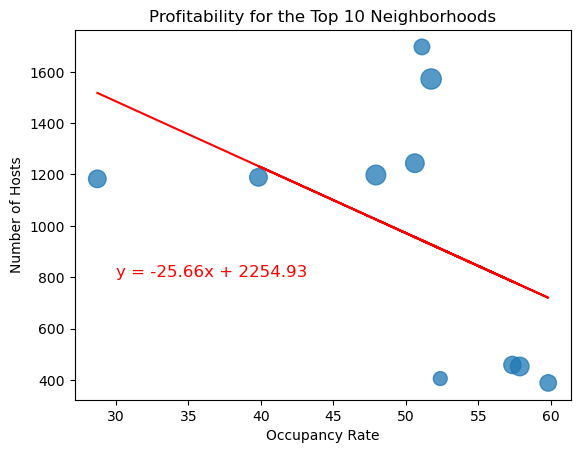

In [147]:
# Creating a scatter plot for the top 10 neighborhoods (x-values = occupancy rate, x-values = number of hosts, size of circle = median price)
x_values = final_result_top_10['occupancy_rate']
y_values = final_result_top_10['host_id']
price = final_result_top_10['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,price,alpha=0.75)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,800),fontsize=12,color='red')
plt.title('Profitability for the Top 10 Neighborhoods')
plt.xlabel('Occupancy Rate')
plt.ylabel('Number of Hosts')
plt.show

print(rvalue)

In [148]:
# Compute for the median rate for the whole population
median_rate = listings_metadata.groupby('neighbourhood')['price'].median()
median_rate.name = 'median_price'
median_rate

neighbourhood
Acton              150.0
Adams-Normandie     80.0
Agoura Hills       150.0
Agua Dulce         115.0
Alhambra           118.0
                   ...  
Willowbrook         99.0
Wilmington         113.0
Windsor Square     152.5
Winnetka           119.5
Woodland Hills     181.0
Name: median_price, Length: 265, dtype: float64

In [187]:
# Compute for the total number of hosts in the population
total_host_id = listings_metadata.value_counts('neighbourhood')
total_host_id.name = 'total_number_host'
total_host_id

neighbourhood
Sherman Oaks         2205
Hollywood            1697
Venice               1572
Long Beach           1542
Santa Monica         1244
                     ... 
Hasley Canyon           2
Walnut Park             2
Cudahy                  2
Lake View Terrace       2
Elizabeth Lake          1
Name: total_number_host, Length: 265, dtype: int64

In [150]:
# Add column to hold information
cleaned_listings["occupancy_rate"]=""

# Compute for occupancy rate per host
for index, row in cleaned_listings.iterrows():
    avail_365 = cleaned_listings.loc[index,'availability_365']
    row = (365-avail_365)/365*100
    cleaned_listings.loc[index,'occupancy_rate'] = row

profit_cleaned_listings = cleaned_listings.loc[:,['host_id','neighbourhood','price','occupancy_rate']]
profit_cleaned_listings



,host_id,neighbourhood,price,occupancy_rate
0,30603612,Pomona,61,92.60274
1,490709958,Castaic Canyons,399,76.164384
2,444692513,Pomona,46,76.164384
3,41736985,Rancho Palos Verdes,408,26.027397
4,208375458,Rancho Palos Verdes,80,2.191781
...,...,...,...,...
42446,38106741,Lancaster,40,0.0
42447,412524751,West Whittier-Los Nietos,48,77.260274
42448,38884077,Diamond Bar,46,75.342466
42449,102942389,El Monte,68,4.109589


In [190]:
# Computing for the mean occupancy rate for the whole population

profit_neighbourhoods = profit_cleaned_listings.groupby('neighbourhood')['occupancy_rate'].mean()
profit_neighbourhoods



neighbourhood
Acton              31.085353
Adams-Normandie    49.974315
Agoura Hills       40.659392
Agua Dulce         47.042111
Alhambra           51.996526
                     ...    
Willowbrook        46.308395
Wilmington         72.727273
Windsor Square     52.208904
Winnetka           37.448630
Woodland Hills     37.276966
Name: occupancy_rate, Length: 265, dtype: float64

In [191]:
# Create new Data Frame for the whole population grouped by neighborhood
new_profit_neighbourhoods = pd.merge(pd.merge(profit_neighbourhoods,median_rate,on='neighbourhood',how='left'),total_host_id,on='neighbourhood',how='left')
new_profit_neighbourhoods


,occupancy_rate,median_price,total_number_host
neighbourhood,,,
Acton,31.085353,150.0,13
Adams-Normandie,49.974315,80.0,32
Agoura Hills,40.659392,150.0,59
Agua Dulce,47.042111,115.0,27
Alhambra,51.996526,118.0,489
...,...,...,...
Willowbrook,46.308395,99.0,39
Wilmington,72.727273,113.0,11
Windsor Square,52.208904,152.5,32


-0.10125548007233943


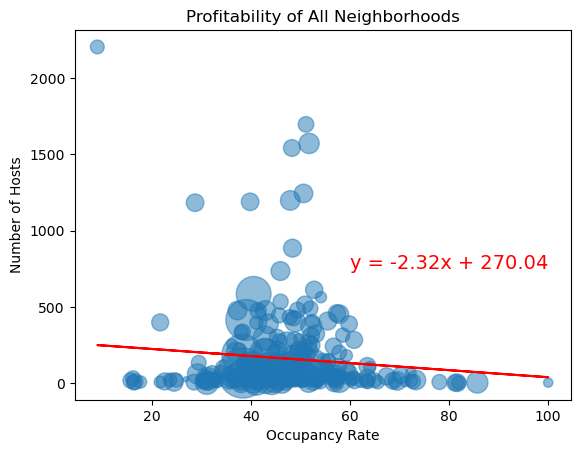

In [192]:
# Create a scatter plot for the whole population (x-values = occupancy rate, y-values = total number of hosts, size of circles = median price)
x_values = new_profit_neighbourhoods['occupancy_rate']
y_values = new_profit_neighbourhoods['total_number_host']
price = new_profit_neighbourhoods['median_price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,price,alpha=0.5)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(60,750),fontsize=14,color="red")
plt.title("Profitability of All Neighborhoods")
plt.xlabel('Occupancy Rate')
plt.ylabel('Number of Hosts')
plt.show

print(rvalue)

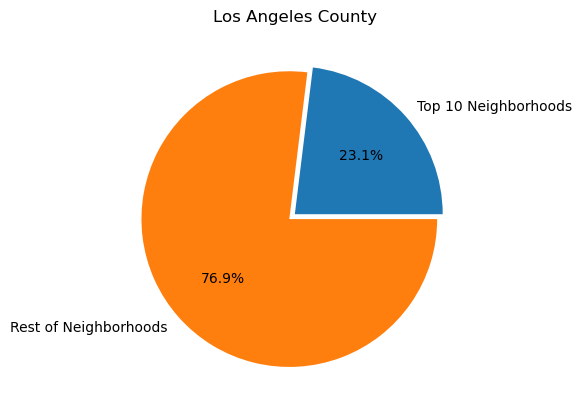

In [155]:
# Pie chart describing the number of hosts for the top 10 vs the rest of the neighborhoods
host = ['Top 10 Neighborhoods','Rest of Neighborhoods']
numbers = [len(top_10_locations['host_id']),(len(listings_metadata['host_id'])-len(top_10_locations['host_id']))]
explode = (0, 0.05)
plt.pie(numbers,labels=host,explode=explode,autopct="%1.1f%%")
plt.title('Los Angeles County')
plt.show()

In [188]:
# Filtering Data Frame
cleaned_df = listings_metadata.loc[:,['host_id','neighbourhood','price','availability_365','license']]
cleaned_df

,host_id,neighbourhood,price,availability_365,license
0,30603612,Pomona,61,27,NaN
1,490709958,Castaic Canyons,399,87,NaN
2,444692513,Pomona,46,87,NaN
3,41736985,Rancho Palos Verdes,408,270,NaN
4,208375458,Rancho Palos Verdes,80,357,NaN
...,...,...,...,...,...
42446,38106741,Lancaster,40,365,NaN
42447,412524751,West Whittier-Los Nietos,48,83,NaN
42448,38884077,Diamond Bar,46,90,NaN
42449,102942389,El Monte,68,350,NaN


In [189]:
# Add column to hold information
cleaned_df["occupancy_rate"]=""

# Compute for occupancy rate per host
for index, row in cleaned_df.iterrows():
    avail_365 = cleaned_df.loc[index,'availability_365']
    row = (365-avail_365)/365*100
    cleaned_df.loc[index,'occupancy_rate'] = row

cleaned_df

,host_id,neighbourhood,price,availability_365,license,occupancy_rate
0,30603612,Pomona,61,27,NaN,92.60274
1,490709958,Castaic Canyons,399,87,NaN,76.164384
2,444692513,Pomona,46,87,NaN,76.164384
3,41736985,Rancho Palos Verdes,408,270,NaN,26.027397
4,208375458,Rancho Palos Verdes,80,357,NaN,2.191781
...,...,...,...,...,...,...
42446,38106741,Lancaster,40,365,NaN,0.0
42447,412524751,West Whittier-Los Nietos,48,83,NaN,77.260274
42448,38884077,Diamond Bar,46,90,NaN,75.342466
42449,102942389,El Monte,68,350,NaN,4.109589


In [158]:
# Grouping all unlicensed hosts
unlicensed_data = cleaned_df.loc[cleaned_df['license'].isnull()]
profit_unlicensed = unlicensed_data.loc[:,['host_id','neighbourhood','price','occupancy_rate']]
profit_unlicensed


,host_id,neighbourhood,price,occupancy_rate
0,30603612,Pomona,61,92.60274
1,490709958,Castaic Canyons,399,76.164384
2,444692513,Pomona,46,76.164384
3,41736985,Rancho Palos Verdes,408,26.027397
4,208375458,Rancho Palos Verdes,80,2.191781
...,...,...,...,...
42446,38106741,Lancaster,40,0.0
42447,412524751,West Whittier-Los Nietos,48,77.260274
42448,38884077,Diamond Bar,46,75.342466
42449,102942389,El Monte,68,4.109589


In [193]:
# Computing average occupancy rate for unlicensed hosts
rate_unlicensed = profit_unlicensed.groupby('neighbourhood')['occupancy_rate'].mean()
rate_unlicensed

neighbourhood
Acton              31.085353
Adams-Normandie    45.616438
Agoura Hills       40.659392
Agua Dulce         47.042111
Alhambra           51.996526
                     ...    
Willowbrook        46.308395
Wilmington         70.616438
Windsor Square     52.287671
Winnetka           35.638068
Woodland Hills     37.508100
Name: occupancy_rate, Length: 263, dtype: float64

In [160]:
# Compute for the number of unlicensed host per neighborhood
unlicensed_host_id = profit_unlicensed.groupby('neighbourhood')['host_id'].count()
unlicensed_host_id.name = 'total_number_host'
unlicensed_host_id

neighbourhood
Acton               13
Adams-Normandie     20
Agoura Hills        59
Agua Dulce          27
Alhambra           489
                  ... 
Willowbrook         39
Wilmington           4
Windsor Square      20
Winnetka            38
Woodland Hills     241
Name: total_number_host, Length: 263, dtype: int64

In [194]:
# Compute for the median price per neighborhood of unlicensed hosts
price_unlicensed = profit_unlicensed.groupby('neighbourhood')['price'].median()
price_unlicensed

neighbourhood
Acton              150.0
Adams-Normandie     97.5
Agoura Hills       150.0
Agua Dulce         115.0
Alhambra           118.0
                   ...  
Willowbrook         99.0
Wilmington         118.5
Windsor Square     125.0
Winnetka            81.0
Woodland Hills     154.0
Name: price, Length: 263, dtype: float64

In [195]:
# Creating a Data Frame by merging all information above
unlicensed_df = pd.merge(pd.merge(unlicensed_host_id,price_unlicensed,on='neighbourhood',how='left'),rate_unlicensed,on='neighbourhood',how='left')
unlicensed_df

,total_number_host,price,occupancy_rate
neighbourhood,,,
Acton,13,150.0,31.085353
Adams-Normandie,20,97.5,45.616438
Agoura Hills,59,150.0,40.659392
Agua Dulce,27,115.0,47.042111
Alhambra,489,118.0,51.996526
...,...,...,...
Willowbrook,39,99.0,46.308395
Wilmington,4,118.5,70.616438
Windsor Square,20,125.0,52.287671


-1.219769231001631e-05


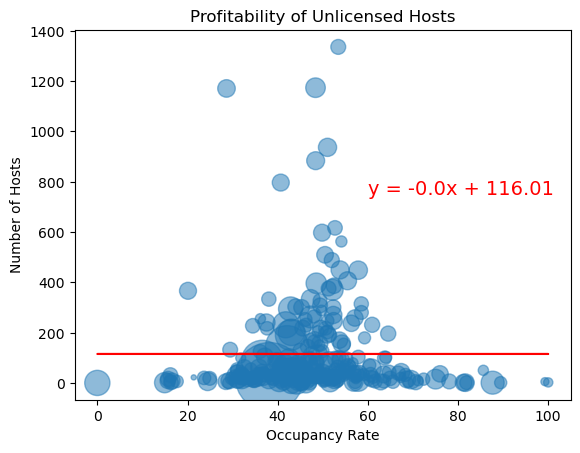

In [196]:
# Creating a scatter plot that describes correlation of occupancy rate vs # of hosts
x_values = unlicensed_df['occupancy_rate']
y_values = unlicensed_df['total_number_host']
price = unlicensed_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,price,alpha=0.5)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(60,750),fontsize=14,color="red")
plt.title("Profitability of Unlicensed Hosts")
plt.xlabel('Occupancy Rate')
plt.ylabel('Number of Hosts')
plt.show

print(rvalue)

In [198]:
# Filtering Data Frame for licensed hosts
licensed_data = cleaned_df.dropna(how='any')
profit_licensed = licensed_data.loc[:,['host_id','neighbourhood','price','occupancy_rate']]
profit_licensed

,host_id,neighbourhood,price,occupancy_rate
5,4182067,Malibu,2138,1.917808
20,492330304,Malibu,593,90.410959
62,474760371,Northridge,175,4.931507
63,410194448,Granada Hills,725,19.452055
64,283511617,Granada Hills,135,0.0
...,...,...,...,...
42430,401130632,Sherman Oaks,199,0.273973
42432,401130632,Sherman Oaks,89,0.273973
42433,401130632,Sherman Oaks,89,0.273973
42438,178996643,Porter Ranch,150,3.835616


In [200]:
# Compute for the average occupancy rate for licensed hosts grouped by neighborhood
rate_licensed = profit_licensed.groupby('neighbourhood')['occupancy_rate'].mean()
rate_licensed

neighbourhood
Adams-Normandie      57.237443
Altadena             82.922374
Arleta               20.456621
Arlington Heights    46.991503
Atwater Village      64.048085
                       ...    
Westwood             56.986301
Wilmington           73.933464
Windsor Square       52.077626
Winnetka             38.634861
Woodland Hills       37.039930
Name: occupancy_rate, Length: 139, dtype: float64

In [202]:
# Compute for the median price per neighborhood
price_licensed = profit_licensed.groupby('neighbourhood')['price'].median()
price_licensed

neighbourhood
Adams-Normandie       65.0
Altadena             109.0
Arleta                90.0
Arlington Heights     40.0
Atwater Village      188.0
                     ...  
Westwood             170.0
Wilmington           113.0
Windsor Square       256.5
Winnetka             128.5
Woodland Hills       291.0
Name: price, Length: 139, dtype: float64

In [204]:
# Compute for the total licensed hosts by neighborhood
licensed_host_id = profit_licensed.groupby('neighbourhood')['host_id'].count()
licensed_host_id

neighbourhood
Adams-Normandie       12
Altadena               3
Arleta                 6
Arlington Heights     79
Atwater Village       49
                    ... 
Westwood              53
Wilmington             7
Windsor Square        12
Winnetka              58
Woodland Hills       235
Name: host_id, Length: 139, dtype: int64

In [206]:
# Creating a Data Frame by merging all information above
licensed_df = pd.merge(pd.merge(licensed_host_id,price_licensed,on='neighbourhood',how='left'),rate_licensed,on='neighbourhood',how='left')
licensed_df

,host_id,price,occupancy_rate
neighbourhood,,,
Adams-Normandie,12,65.0,57.237443
Altadena,3,109.0,82.922374
Arleta,6,90.0,20.456621
Arlington Heights,79,40.0,46.991503
Atwater Village,49,188.0,64.048085
...,...,...,...
Westwood,53,170.0,56.986301
Wilmington,7,113.0,73.933464
Windsor Square,12,256.5,52.077626


-0.15146120505769936


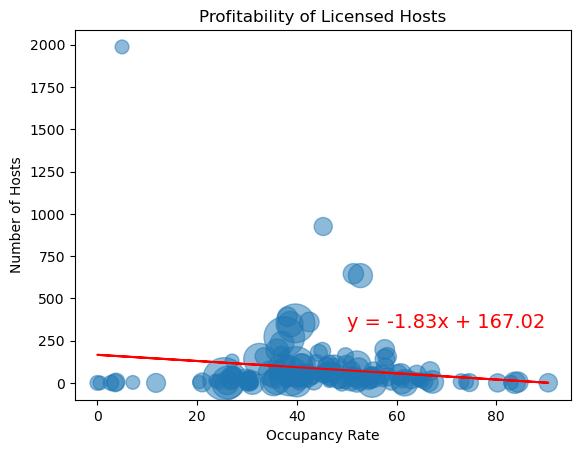

In [208]:
# Create a scatter plot that describes occupancy rate vs number of hosts with the size of the circles as median price
x_values = licensed_df['occupancy_rate']
y_values = licensed_df['host_id']
price = licensed_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,price,alpha=0.5)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(50,325),fontsize=14,color="red")
plt.title('Profitability of Licensed Hosts')
plt.xlabel('Occupancy Rate')
plt.ylabel('Number of Hosts')
plt.show

print(rvalue)

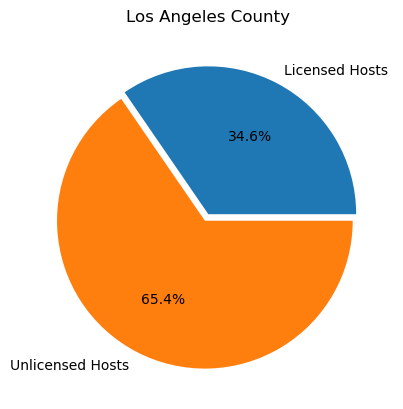

In [209]:
# Pie chart describing the distribution of licensed and unlicensed hosts
host = ['Licensed Hosts','Unlicensed Hosts']
numbers = [len(licensed_df['host_id']),(len(unlicensed_df['total_number_host']))]
explode = (0, 0.05)
plt.pie(numbers,labels=host,explode=explode,autopct="%1.1f%%")
plt.title('Los Angeles County')
plt.show()